# Gaussian Discriminative Analysis (GDA)

##### *October 8, 2019 Pr: Jae Yun JUN KIM*

In [0]:
# import Librairies
import pandas as pd
import numpy as np
import random as rd 
import matplotlib.pyplot as plt

### Tasks

#### 1. Download the data.csv file which contains one hundred of examples with two features and the corresponding label.

In [0]:
# URL of the csv file containing the data on GitHub
url = 'https://raw.githubusercontent.com/MaxTeiger/discriminative-and-generative-models/master/data.csv'

# Parsing the file into a Pandas DataFrame
datas = pd.read_csv(url, names=['x1', 'x2', 'y'])

datas.head()

,x1,x2,y
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0


#### 2. Read the data file, considering 80% of data as the training set and the rest for the test set.

In [0]:
def splitTrainingTest(initialDF, train_size = 0.8):
  
    #Initialization
    trainIndex, testIndex = list(), list()
    
    # We iterate over the DataFrame and put 80% of the inputs 
    # in the training set and the rest in the test set
    for i in range(initialDF.shape[0]):
        if np.random.uniform(0, 1) < train_size:
            trainIndex += [i]
        else:
            testIndex += [i]
    
    # Locate all lines in the initial dataframe at indexes 
    # specified for each training and testing set
    trainData = initialDF.loc[trainIndex]
    testData = initialDF.loc[testIndex]
    
    # Reset index for both sets
    trainData.reset_index(inplace = True)
    trainData.drop(['index'], axis = 1, inplace = True)
    trainData.head()
    testData.reset_index(inplace = True)
    testData.drop(['index'], axis = 1, inplace = True)
    testData.head()
    
    return trainData, testData

In [0]:
# Splitting datas into training and testing set
train_datas, test_datas = splitTrainingTest(datas)

In [0]:
print("Number of rows in training set:", train_datas.shape[0])
print("Number of rows in test set:", test_datas.shape[0])
print('Number of total rows: ', train_datas.shape[0]+test_datas.shape[0], "\n")
print(train_datas['y'].value_counts(), '\n')
print(test_datas['y'].value_counts())

Number of rows in training set: 78
Number of rows in test set: 22
Number of total rows:  100 

1    41
0    37
Name: y, dtype: int64 

0    13
1     9
Name: y, dtype: int64


#### 3. Solve the classification problem using both methods that you learned in class (the training part):


##### Logistic regression (an example of discriminative models)

###### Partie cours

Le but est de trouver le y *(output)* qui maximise la probabilité : 

> $P( Y = y | X )$

Pour ce problème on utilise généralement la fonction sigmoide :

![Fonction Sigmoide](http://saedsayad.com/images/ANN_Sigmoid.png)

On dit donc que : 

> $P( Y = 1 | X ; Ɵ) =$ $h_Ɵ$( $X^{(i)}$ ) 

et que : 

> $P(Y=0|X;Ɵ)=1-h_Ɵ(x^{(i)})$

On peut en déduire facilement que : 

> $P ( Y = 1 | X ; Ɵ) = h_Ɵ( X^{(i)} )^{(y)}( 1 -h_Ɵ( X^y ))^{(1 - y)}$ 

---

**Performance Measures : Conditional Likelihood**

We use conditional probability,  so we use conditional likelihood $L(Ɵ)$

The conditional likelihood is defined as : 

> $ L(Ɵ)=P( Y | X ; Ɵ )$

But as we consider the distribution to be identically and independently distributed, we can deduce : 
> $ L(Ɵ)=$$\prod_{i=1}^{I} P(Y^{(i)} | X^{(i)};Ɵ)$

> $ L(Ɵ)=$$\prod_{i=1}^{I} [ h_Ɵ$( $X^{(i)}$ $)^{(y^{(i)})}$ 
> $( 1 - h_Ɵ( X^{(i)})^{(1 - y^{(i)})}] $

From the previous calculation.

But this is not good, we are indeed multiplying probabilities many times, the likelihood will tend towards $0$.

The solution is to use the conditional log-likelihood : 

$l(\theta) = \log(L(\theta)) = \sum_{i=0}^I y^{(i)}h_{\theta}(x^{(i)})+(1-y^{(i)})(1-h_{\theta}(x^{(i)})$


---

**The goal is finding $\theta$ for which $l(\theta)$ is higher**

To serve this purpose, we use the gradient ascent : 


$n = {1, ... , N}$ $\leftarrow$ Nb of features


$\theta_n^{(itera)} \leftarrow \theta_n^{(itera-1)} \color{red}{+} \alpha . \frac{dl}{d\theta_n} $ (Scalar)

$\theta^{(itera)} \leftarrow \theta^{(itera-1)} \color{red}{+} \alpha .  ▽_{\theta}l(\theta)$ (Vector)



We need to compute :

$\frac{dl}{d\theta_n} = \sum_{i=0}^I (y^{(i)} - h_{\theta}(x^{(i)}))x_n^{(i)}$

Indeed, we have : 

> $\theta_n^{(itera)} \leftarrow \theta_n^{(itera-1)} \color{red}{+} \alpha . \sum_{i=0}^I (y^{(i)} - h_{\theta}(x^{(i)})x_n^{(i)} $ 



###### Partie code

In [0]:
class DiscriminativeClassifier():
    
    def __init__(self):
        # Our two weights initialized randomly between -1 and 1
        self.theta = None
        
        self.dl_theta = None
        
        # Learning rates
        self.alpha = 0.005
        
        # Number of features
        self.N = 0
        
        # Number of training examples
        self.I = 0
        
        # Error
        self.err = []
        self.histdl = []
        self.histTheta = []

        self.y_hat = []
        
    
    def sigmoid_function(self, X):
        """Takes an X[i] as an input and compute the sigmoid function with it, 
        gives the probability that Y=1 depending on X[i], computed with theta 
        parameters
        """
        
        h_theta = 1 / ( 1+np.exp ( np.dot ( -self.theta, X ) ) )
        
        return h_theta
      
    def c_log_likelihood(self, X, y):
      """
      Compute the log likelihood given X and y 
      """
      l_theta = 0
      for i in range(self.I):
        l_theta += y[i]*self.sigmoid_function(X[i]) + (1 - y[i])*(1 - self.sigmoid_function(X[i]))
        
      return l_theta
      
    
    def conditional_propability(self, X):
        return None

    def plot_hist(self):
        plt.plot(np.arange(len(self.err)), self.err)
        plt.title('Likelihood')
        plt.show()
        
        plt.plot(np.arange(len(self.histTheta)), self.histTheta, label='Theta')
        plt.legend()
        plt.title('Theta')
        plt.show()
        
        plt.plot(np.arange(len(self.histdl)), self.histdl, label='dL/dTheta')
        plt.legend()
        plt.title('dL')
        plt.show()
    
    def c_dl_theta(self, X, y):
        """
        Compute the derivative of theta given X and y 
        """
        self.dl_theta = np.array([0.]*self.N) 
        
        for n in range(self.N):
          for i in range(self.I):
            self.dl_theta[n] += (y[i]-self.sigmoid_function(X[i]))*X[i,n]
            
#         print('DL/DTHETA : ', self.dl_theta)
    
    def fit(self, X, y, nb_epoch=50):
        
        # define training examples and number of features
        self.N = X.shape[1] # Here 2 features 
        self.I = X.shape[0] # Here approx. 80 training examples
        
        # define an N-array for Theta and dl theta 
        self.dl_theta = np.array([0.]*self.N) 
        self.theta = np.array([np.random.normal(1.0, 0.5)] * self.N)
        
        print("Initial Theta : ", self.theta, "\nInitial dl/dTheta : ", self.dl_theta)
        print("Number of features : ", self.N, "\nNumber of Tr. Examples : ", self.I)
        
        
        for e in range(nb_epoch):
          
#           print('loop ', e )
#           print("Theta : ", self.theta, "\tdl : ", self.dl_theta)
          
          #  Keep trace of the parameters
          self.err.append(self.c_log_likelihood(X,y))
          self.histdl.append(self.dl_theta)
          self.histTheta.append([self.theta[0], self.theta[1]])
          
          # calculate dl/dtheta
          self.c_dl_theta(X, y)                 
          
          # actualize theta
          self.theta+=self.alpha*self.dl_theta
          
          
          
        self.plot_hist()
        
                                                                    
        
    def predict_one(self, X):
      if self.sigmoid_function(X) > 0.5:
        return 1
      else: 
        return 0
    
    def predict(self, X, y):
      
      self.y_hat = []

      # For each test example
      print("|\tx1\t|\tx2\t|\ty\t|\ty_hat\t|\n" +\
      "-"*65)
      for i in range(len(X)):
        print("|\t"+str(X[i,0])+"\t|\t"+str(X[i,1])+"\t|\t"+str(y[i])+"\t" \
             "|\t"+str(self.predict_one(X[i]))+"\t|")
        print("-"*65)

        self.y_hat.append(self.predict_one(X[i]))

    def confusion_matrix(self, y):

        true_pos, false_pos, true_neg, false_neg = 0, 0, 0, 0

        for i  in range(len(y)):
          if self.y_hat[i] == 1 and y[i]==1:
            true_pos+=1
          elif self.y_hat[i] == 1 and y[i]==0:
            false_pos +=1
          elif self.y_hat[i] == 0 and y[i] ==0:
            true_neg+=1
          elif self.y_hat[i] == 0 and y[i] == 1:
            false_neg+=1
        
        print("TP: {}, FP: {}, TN: {}, FN: {}".format(true_pos, false_pos, true_neg, false_neg))
        
     
        
     
     


Initial Theta :  [0.87672442 0.87672442] 
Initial dl/dTheta :  [0. 0.]
Number of features :  2 
Number of Tr. Examples :  78


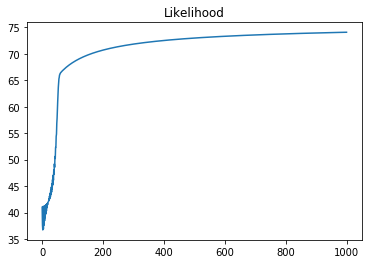

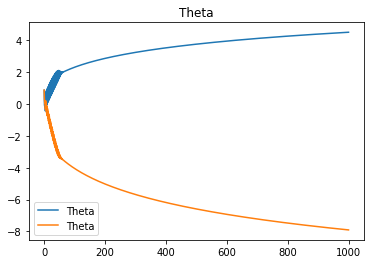

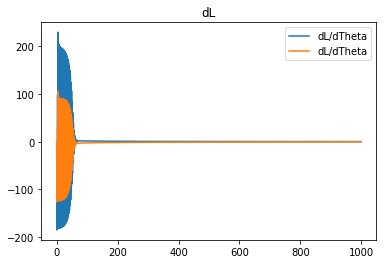

In [0]:
test = DiscriminativeClassifier()
x_train, y_train  = train_datas.drop(columns='y').values, train_datas['y'].values
test.fit(x_train, y_train, nb_epoch=1000)

In [0]:
x_test, y_test  = test_datas.drop(columns='y').values, test_datas['y'].values
test.predict(x_test, y_test)

|	x1	|	x2	|	y	|	y_hat	|
-----------------------------------------------------------------
|	4.7	|	3.2	|	0	|	0	|
-----------------------------------------------------------------
|	5.0	|	3.4	|	0	|	0	|
-----------------------------------------------------------------
|	5.1	|	3.8	|	0	|	0	|
-----------------------------------------------------------------
|	5.4	|	3.4	|	0	|	0	|
-----------------------------------------------------------------
|	5.2	|	3.5	|	0	|	0	|
-----------------------------------------------------------------
|	4.7	|	3.2	|	0	|	0	|
-----------------------------------------------------------------
|	4.8	|	3.1	|	0	|	0	|
-----------------------------------------------------------------
|	5.2	|	4.1	|	0	|	0	|
-----------------------------------------------------------------
|	5.5	|	4.2	|	0	|	0	|
-----------------------------------------------------------------
|	5.5	|	3.5	|	0	|	0	|
-----------------------------------------------------------------
|	4.4	|	3.0	|	0	|	0	|
--------

In [0]:
test.confusion_matrix(y_test)

TP: 9, FP: 0, TN: 13, FN: 0


##### Gaussian Discriminant Analysis (an example of generative models)

###### Partie Cours

The objective we have is to find :

> $argmax_y P(X|Y)P(Y)$

We supposed that Y is following Bernouilli rule : 

> $P(Y;\phi) = \phi^y \times(1-\phi)^{(1-y)}$ where $P(Y = 1; \phi)\ne0$
     
       
$X|Y=0$ suit une loi normale de paramètres $N(\mu_0, \epsilon)$

$X|Y=1$ suit une loi normale de paramètres $N(\mu_1, \epsilon)$

By definition, we assume that :

$P(X|Y=0) = \frac{1}{(2\pi)^{\frac{N}{2}}(det(\epsilon))^{\frac{1}{2}}}.exp[-(X-\mu_0)^{T}\epsilon^{-1}(X-\mu_0)]$

$P(X|Y=1) = \frac{1}{(2\pi)^{\frac{N}{2}}(det(\epsilon))^{\frac{1}{2}}}.exp[-(X-\mu_1)^{T}\epsilon^{-1}(X-\mu_1)]$

----

Here we use joint probabilities, so we have to compute the joint log-likelihood : 

> $l(\theta)=logP(X, Y; \theta)$
>
> $l(\theta)=log\prod_{i=1}^I P(X^{(i)}|Y^{(i)};\theta)P(Y^{(i)})  $ 

avec $\theta = (\phi, \mu_0, \mu_1, \epsilon)$

With the Maximum Likelihood Estimation (MLE), we can compute : 

${\mu_0}_{MLE} = \frac{\sum_{i=1}^I || \{y^{(i)} =0\}x^{(i)}}{\sum_{i=1}^I || \{y^{(i)}=0\}}$


${\mu_1}_{MLE} = \frac{\sum_{i=1}^I || \{y^{(i)} =1\}x^{(i)}}{\sum_{i=1}^I || \{y^{(i)}=1\}}$


${\phi}_{MLE} = \frac{\sum_{i=1}^I || \{y^{(i)} =1\}}{I}$

$\epsilon_{MLE} = \frac{1}{I}\sum_{i=1}^I (X^{(i)}-\mu_{y^{(i)}})(X^{(i)}-\mu_{y^{(i)}})^T$

###### Partie code


In [0]:
class GenerativeClassifier():
    
    def __init__(self):
      
      # Model parameters
      self.mu_0 = None
      self.mu_1 = None
      self.phi = None
      self.eps = None
      
      # Learning rates
      self.alpha = 0.005
        
      # Number of features
      self.N = 0
        
      # Number of training examples
      self.I = 0

      self.y_hat = []
              
    def c_log_likelihood(self, X, y):
      """
      Compute the log likelihood given X and y 
      """

      return l_theta
      
    
    def c_px_y0(self, X):
        """ 
        """
        det_eps = np.linalg.det(self.eps)
        pi = np.pi
        X = np.matrix(X)
        px_y0 = ( 1 / ( ((2*pi)**(self.N/2)) * det_eps**(1/2) ) ) \
              * np.exp( (-1/2)*( X-self.mu_0 ) * np.linalg.inv(self.eps) \
              * (X.T-self.mu_0) )  
       
        return px_y0

    def c_px_y1(self, X):
        """
        """
        
        det_eps = np.linalg.det(self.eps)
        pi = np.pi
        X = np.matrix(X)
        px_y1 = ( 1 / ( (2*pi)**(self.N/2) * det_eps**(1/2) ) ) \
              * np.exp( (-1/2)*( X-self.mu_1 ) * np.linalg.inv(self.eps) \
              * (X.T-self.mu_1) )  

        return px_y1
      
    def c_py(self, y):
      """
      """
      p_y = self.phi**(y) * (1-self.phi)**(1-y)
      
      return p_y
    
    def predict_one(self, X):

      px_y0 = self.c_px_y0(X)
      px_y1 = self.c_px_y1(X)
      py0 = self.c_py(0)
      py1 = self.c_py(1)
      
      if px_y0*py0 > px_y1*py1:
        return 0
      elif px_y1*py1 > px_y0*py0:
        return 1 
        
    def c_phi(self, y):
      num = 0
        
      for i in range(self.I):
        if y[i] == 1:
          num+=1
              
      return num/self.I
    
    def c_mu_0(self, X, y):
      
        num, denom = 0, 0
        
        for i in range(self.I):
          if y[i] == 0:
            denom += 1
            for n in range(self.N):
              num+=X[i, n]
              
        return num/denom
      
    def c_mu_1(self, X, y):
        
        num, denom = 0, 0
        
        for i in range(self.I):
          if y[i] == 1:
            denom += 1
            for n in range(self.N):
              num+=X[i, n]
              
        return num/denom
      
    def c_eps(self, X, y):
        """
        Should return a NxN matrix 
        """
        num = np.matrix([[0.]*self.N]*self.N)
        
        for i in range(self.I):
          
          temp = np.matrix([0]*self.N)
          if y[i]==0:
            temp = np.matrix(X[i])-self.mu_0
            num += np.dot(temp.T, temp)
          elif y[i]==1:
            temp = np.matrix(X[i])-self.mu_1
            num += np.dot(temp.T, temp)

        eps = num/self.I
        
        return eps
    
    
    def fit(self, X, y):
        
        # define training examples and number of features
        self.N = X.shape[1] # Here 2 features 
        self.I = X.shape[0] # Here approx. 80 training examples
        
        self.mu_0 = self.c_mu_0(X, y)
        self.mu_1 = self.c_mu_1(X, y)
        self.phi = self.c_phi(y)
        self.eps = self.c_eps(X, y)
        
        print("MU 0 : ", self.mu_0)
        print("MU 1 : ", self.mu_1)
        print("Phi  : ", self.phi)
        print("Epsilon : ", self.eps)
        
        
    def predict(self, X, y):
      
      # For each test example
      print("|\tx1\t|\tx2\t|\ty\t|\ty_hat\t|\n" +\
      "-"*65)
      for i in range(len(X)):
        print("|\t"+str(X[i,0])+"\t|\t"+str(X[i,1])+"\t|\t"+str(y[i])+"\t" \
             "|\t"+str(self.predict_one(X[i]))+"\t|")
        print("-"*65)

        self.y_hat.append(self.predict_one(X[i]))

    def confusion_matrix(self, y):

        true_pos, false_pos, true_neg, false_neg = 0, 0, 0, 0

        for i  in range(len(y)):
          if self.y_hat[i] == 1 and y[i]==1:
            true_pos+=1
          elif self.y_hat[i] == 1 and y[i]==0:
            false_pos +=1
          elif self.y_hat[i] == 0 and y[i] ==0:
            true_neg+=1
          elif self.y_hat[i] == 0 and y[i] == 1:
            false_neg+=1
        
        print("TP: {}, FP: {}, TN: {}, FN: {}".format(true_pos, false_pos, true_neg, false_neg))
        
     


In [57]:
model = GenerativeClassifier()
x_train, y_train  = train_datas.drop(columns='y').values, train_datas['y'].values
model.fit(x_train, y_train)

MU 0 :  8.424324324324328
MU 1 :  8.739024390243907
Phi  :  0.5256410256410257
Epsilon :  [[ 9.8158098  16.92846154]
 [16.92846154 30.66239533]]


In [58]:
x_test, y_test  = test_datas.drop(columns='y').values, test_datas['y'].values
model.predict(x_test, y_test)
model.confusion_matrix(y_test)

|	x1	|	x2	|	y	|	y_hat	|
-----------------------------------------------------------------
|	4.7	|	3.2	|	0	|	0	|
-----------------------------------------------------------------
|	5.0	|	3.4	|	0	|	0	|
-----------------------------------------------------------------
|	5.1	|	3.8	|	0	|	0	|
-----------------------------------------------------------------
|	5.4	|	3.4	|	0	|	0	|
-----------------------------------------------------------------
|	5.2	|	3.5	|	0	|	0	|
-----------------------------------------------------------------
|	4.7	|	3.2	|	0	|	0	|
-----------------------------------------------------------------
|	4.8	|	3.1	|	0	|	0	|
-----------------------------------------------------------------
|	5.2	|	4.1	|	0	|	0	|
-----------------------------------------------------------------
|	5.5	|	4.2	|	0	|	0	|
-----------------------------------------------------------------
|	5.5	|	3.5	|	0	|	0	|
-----------------------------------------------------------------
|	4.4	|	3.0	|	0	|	0	|
--------

#### 4. Compare the results of training with the two methods.

#### 5. Test the optimized parameters with the test data